<a href="https://colab.research.google.com/github/GUILLENJV/SHM_AI/blob/master/Hyperparameters_by_Bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization

Como recordatorio rápido, el ajuste de hiperparámetros es una parte fundamental de un proyecto de aprendizaje automático. Hay dos tipos de hiperparámetros:

1. Hiperparámetros estructurales : definen la arquitectura general de un modelo (por ejemplo, número de unidades ocultas , número de capas )

2. Hiperparámetros del optimizador: influyen en la velocidad y la calidad del entrenamiento (por ejemplo , tasa de aprendizaje y tipo de optimizador , tamaño del lote , número de épocas )

Afortunadamente, el sintonizador Keras proporciona un sintonizador de optimización bayesiana . En lugar de buscar todas las combinaciones posibles, el sintonizador de optimización bayesiana sigue un proceso iterativo, en el que elige las primeras al azar. Luego, en función del rendimiento de esos hiperparámetros, el sintonizador bayesiano selecciona el siguiente mejor posible.

Así, cada elección de hiperparámetros depende de los intentos previos. El número de iteraciones para elegir el siguiente conjunto de hiperparámetros en función del historial y la evaluación del rendimiento continúa hasta que el sintonizador encuentra la mejor combinación o agota el número máximo de intentos . Podemos configurar esto con el argumento ' max_trials '.


In [ ]:
# example of learned embedding encoding for a neural network
from numpy import unique
import numpy
from numpy import array
import pandas as pd
import datetime 
from time import sleep
from tqdm import tqdm
import os
from pandas import read_csv
from sklearn.model_selection import train_test_split
import json
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# carga los datos
df = pd.read_csv('631d8277776f1d001a21e6eb.csv') 
df = df.drop_duplicates()

df["visitor_device_hardware_family"] = df["visitor_device_hardware_family"].apply(str)
df["visitor_device_hardware_model"] = df["visitor_device_hardware_model"].apply(str)
df["visitor_device_os_version"] = df["visitor_device_os_version"].apply(str)
df["visitor_device_hardware_family"] = df["visitor_device_hardware_family"].apply(str)
df["visitor_device_hardware_model"] = df["visitor_device_hardware_model"].apply(str)
df["visitor_device_os_version"] = df["visitor_device_os_version"].apply(str)
df["visitor_tokens_adh"] = df["visitor_tokens_adh"].apply(str)
df["visitor_tokens_cadid"] = df["visitor_tokens_cadid"].apply(str)
df["converted_yes"] = df["converted_yes"].apply(str)
df["converted_no"] = df["converted_no"].apply(str)

# Imputamos la variable 
df['visitor_device_os_vendor'].fillna(df['visitor_device_os_vendor'].mode()[0], inplace=True)
df['campaign_id'].fillna(df['campaign_id'].mode()[0], inplace=True)
df['visitor_device_hardware_vendor'].fillna(df['visitor_device_hardware_vendor'].mode()[0], inplace=True)
df['visitor_device_browser'].fillna(df['visitor_device_browser'].mode()[0], inplace=True)
df['traffic_source_id'].fillna(df['traffic_source_id'].mode()[0], inplace=True)
df['landing_page_id'].fillna(df['landing_page_id'].mode()[0], inplace=True)
df['visitor_device_os_family'].fillna(df['visitor_device_os_family'].mode()[0], inplace=True)
df['visitor_device_type'].fillna(df['visitor_device_type'].mode()[0], inplace=True)
df['visitor_geo_location_countryCode'].fillna(df['visitor_geo_location_countryCode'].mode()[0], inplace=True)
df['visitor_geo_location_regionName'].fillna(df['visitor_geo_location_regionName'].mode()[0], inplace=True)
df['visitor_tokens_adi'].fillna(df['visitor_tokens_adi'].mode()[0], inplace=True)
df['visitor_geo_location_isp'].fillna(df['visitor_geo_location_isp'].mode()[0], inplace=True)
df['visitor_geo_location_connection_type'].fillna(df['visitor_geo_location_connection_type'].mode()[0], inplace=True)
df['visitor_geo_location_cityName'].fillna(df['visitor_geo_location_cityName'].mode()[0], inplace=True)

df = df.drop(['landing_pages_group_id','visitor_tokens_add'], axis=1)

X = df[['campaign_id', 'traffic_source_id',
       'visitor_device_browser', 'visitor_device_hardware_family',
       'visitor_device_hardware_model', 'visitor_device_hardware_vendor',
       'visitor_device_os_family', 'visitor_device_os_vendor',
       'visitor_device_os_version', 'visitor_device_type',
       'visitor_geo_location_cityName', 'visitor_geo_location_connection_type',
       'visitor_geo_location_countryCode', 'visitor_geo_location_isp',
       'visitor_geo_location_regionName', 'visitor_tokens_adh',
       'visitor_tokens_cadid', 'visitor_tokens_adi', 'converted_yes',
       'converted_no']]

X = X.astype(str).to_numpy()
y = df[["landing_page_id"]].to_numpy()

# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    feature = feature.reshape(X.shape[0], 1)
    onehot_encoder = OrdinalEncoder()
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = numpy.concatenate((encoded_x, feature), axis=1)
#print("X shape: : ", encoded_x.shape)

# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
dummy_y = np_utils.to_categorical(label_encoded_y)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_x, dummy_y, test_size=0.30, random_state=123)

scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df["landing_page_id"].value_counts()

631d72ff99ba21001a8503fa    2624
631d779999ba21001a850416    2618
62566aa432b19a0164d802be    2598
Name: landing_page_id, dtype: int64

In [ ]:
df.shape

(7840, 21)

# Generando el primer modelo sin optimizar los hiperparametros

# 1. Batch Size and Number of Epochs

In [ ]:
# Definición del modelo
def modelo_mlp(): 
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    model.summary()
    return model

In [ ]:
model = modelo_mlp()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos el modelo con el dataset
history=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
172/172 [==============================] - 1s 3ms/step - loss: 1.0686 - accuracy: 0.4233 - val_loss: 0.9053 - val_accuracy: 0.5480
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 0.8326 - accuracy: 0.5621 - val_loss: 0.7627 - val_accuracy: 0.5906
Epoch 3/100
172/172 [==============================] - 0s 3ms/step - loss: 0.7343 - accuracy: 0.5878 - val_loss: 0.6999 - val_accuracy: 0.6033
Epoch 4/100
172/172 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5977 - val_loss: 0.6708 - val_accuracy: 0.6139
Epoch 5/100
172/172 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6077 - val_loss: 0.6529 - val_accuracy: 0.6101
Epoch 6/100
172/172 [==============================] - 0s 2ms/step - loss: 0.6521 - accuracy: 0.6113 - val_loss: 0.6395 - val_accuracy: 0.6148
Epoch 7/100
172/172 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6142 - val_loss: 0.6284 - val_accuracy: 0.6131

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))

Precisión Entrenamiento: 0.7032
Precisión Prueba:  0.6386


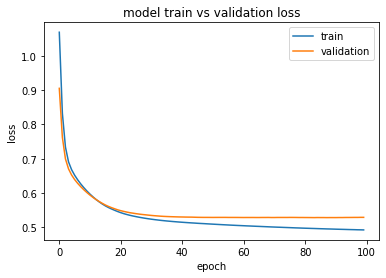

In [ ]:
from matplotlib import pyplot
from numpy import array
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Generando el primer modelo optimizando los hiperparametros

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.4 MB/s 
     |████████████████████████████████| 1.6 MB 44.8 MB/s 


In [ ]:
#Destroy Old Oracle
!rm -rf tuning-mlp

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pickle
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  app.launch_new_instance()


In [ ]:
### Tunable Model
def mlp_model_builder(hp):
  model = Sequential()
 
  
  model.add(Dense(units = hp.Int('dense-bot', min_value=1, max_value=25, step=16), input_shape=(20,), activation='relu'))
  for i in range(hp.Int('num_dense_layers', 1, 2)):
    model.add(Dense(units=hp.Int('dense_' + str(i), min_value=50, max_value=100, step=25), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))
  model.add(Dense(3,activation="softmax"))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer == 'SGD':
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
      nesterov=True
      momentum=0.9

  model.compile( optimizer=hp_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# set random seed
random_seed = 8
tf.random.set_seed = random_seed
np.random.seed(random_seed)

In [ ]:
# Overload arguments with our custom metric.
tuner_mlp = kt.tuners.BayesianOptimization(
    mlp_model_builder,
    seed=random_seed,
    objective='val_loss',
    max_trials=30,
    directory='.',
    project_name='tuning-mlp')

In [ ]:
### Search Space 
tuner_mlp.search(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Trial 30 Complete [00h 01m 23s]
val_loss: 0.5317756533622742

Best val_loss So Far: 0.5106295943260193
Total elapsed time: 00h 36m 17s


In [ ]:
best_mlp_hyperparameters = tuner_mlp.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters.values

Best Hyper-parameters


{'dense-bot': 17,
 'num_dense_layers': 2,
 'dense_0': 50,
 'dropout_0': 0.2,
 'Optimizer': 'Adam',
 'learning_rate': 0.001,
 'dense_1': 100,
 'dropout_1': 0.0}

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(best_mlp_hyperparameters['dense-bot'], input_shape=(20,), activation='relu'))
for i in range(best_mlp_hyperparameters['num_dense_layers']):
  model_mlp.add(Dense(units=best_mlp_hyperparameters['dense_' +str(i)], activation='relu'))
  model_mlp.add(Dropout(rate=best_mlp_hyperparameters['dropout_' +str(i)]))
model_mlp.add(Dense(3,activation="softmax"))

model_mlp.compile(optimizer=best_mlp_hyperparameters['Optimizer'], 
                                                 loss='categorical_crossentropy', 
                                                 metrics=['accuracy'])
history_mlp= model_mlp.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
172/172 [==============================] - 1s 4ms/step - loss: 0.9112 - accuracy: 0.4971 - val_loss: 0.6849 - val_accuracy: 0.6093
Epoch 2/100
172/172 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.6115 - val_loss: 0.6200 - val_accuracy: 0.6284
Epoch 3/100
172/172 [==============================] - 1s 4ms/step - loss: 0.6318 - accuracy: 0.6217 - val_loss: 0.5998 - val_accuracy: 0.6233
Epoch 4/100
172/172 [==============================] - 1s 4ms/step - loss: 0.6098 - accuracy: 0.6226 - val_loss: 0.5835 - val_accuracy: 0.6378
Epoch 5/100
172/172 [==============================] - 1s 4ms/step - loss: 0.5896 - accuracy: 0.6306 - val_loss: 0.5720 - val_accuracy: 0.6314
Epoch 6/100
172/172 [==============================] - 1s 4ms/step - loss: 0.5751 - accuracy: 0.6383 - val_loss: 0.5595 - val_accuracy: 0.6424
Epoch 7/100
172/172 [==============================] - 1s 4ms/step - loss: 0.5609 - accuracy: 0.6498 - val_loss: 0.5504 - val_accuracy: 0.6514

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))

Precisión Entrenamiento: 0.7032
Precisión Prueba:  0.6386


In [ ]:
print(model_mlp.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 17)                357       
                                                                 
 dense_4 (Dense)             (None, 50)                900       
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 100)               5100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 303       
                                                                 
Total params: 6,660
Trainable params: 6,660
Non-traina

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from matplotlib.pyplot import *

In [ ]:
from matplotlib import *

In [ ]:
import matplotlib

In [ ]:
from matplotlib.pyplot import *

In [ ]:
history_mlp

In [ ]:
plt(
    hs={
        'Best MLP': history_mlp
    },
    epochs=25,
    loss='loss')

plt(
    hs={
        'Best MLP': history_mlp
    },
    epochs=25, 
    metrics='accuracy')

In [ ]:
#Calculate accuracies
mlp_train_loss, mlp_train_acc = model_mlp.evaluate(X_train,  y_train, verbose=2)
print('\nTrain accuracy:', mlp_train_acc)

mlp_dev_loss, mlp_dev_acc = model_mlp.evaluate(X_train,  y_train, verbose=2)
print('\nValidation accuracy:', mlp_dev_acc)

mlp_test_loss, mlp_test_acc = model_mlp.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', mlp_test_acc)

172/172 - 0s - loss: 0.4088 - accuracy: 0.7748 - 229ms/epoch - 1ms/step

Train accuracy: 0.774781346321106
172/172 - 0s - loss: 0.4088 - accuracy: 0.7748 - 233ms/epoch - 1ms/step

Validation accuracy: 0.774781346321106
74/74 - 0s - loss: 0.5967 - accuracy: 0.6369 - 135ms/epoch - 2ms/step

Test accuracy: 0.636904776096344


In [ ]:
best_mlp_hyperparameters = tuner_mlp.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters.values

Best Hyper-parameters


{'dense-bot': 17,
 'num_dense_layers': 2,
 'dense_0': 50,
 'dropout_0': 0.2,
 'Optimizer': 'Adam',
 'learning_rate': 0.001,
 'dense_1': 100,
 'dropout_1': 0.0}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
class_names = ['631d72ff99ba21001a8503fa', '631d779999ba21001a850416', '62566aa432b19a0164d802be']

In [ ]:
predictions=model_mlp.predict(X_test)

plot_confusion_matrix(tf.argmax(predictions, axis = 1).numpy(), tf.argmax(y_test, axis = 1).numpy(),  classes=class_names, title='Confusion matrix on best MLP results')
plt.show()

In [ ]:
631d72ff99ba21001a8503fa    2624
631d779999ba21001a850416    2618
62566aa432b19a0164d802be 

74/74 [==============================] - 0s 1ms/step


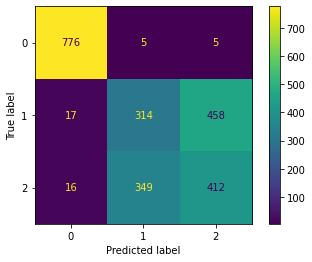

In [ ]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       786
           1       0.47      0.40      0.43       789
           2       0.47      0.53      0.50       777

    accuracy                           0.64      2352
   macro avg       0.63      0.64      0.63      2352
weighted avg       0.63      0.64      0.63      2352

